In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time
import math
import copy
import operator
import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import imageio

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

import gym

%autosave 180

Autosaving every 180 seconds


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the Environment

In [3]:
seed = 7
env = gym.make('CartPole-v0')
env.seed(seed)
nA = env.action_space.n
nS = env.observation_space.shape[0]
print('state space',nS)
print('action space',nA)

state space 4
action space 2


/anaconda3/envs/torch/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


# Plot functions

In [4]:
def plot(scores):
    # Rolling mean plot
    interval = 5
    rolling_mean = [np.mean(scores[(slice_*interval):(slice_+1)*interval]) for slice_ in range(math.ceil(len(scores)/interval))]
    x_axis = np.arange(len(rolling_mean)) * interval
    plt.plot(x_axis, rolling_mean)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

# Policy Gradients

A suite of methods where we optimize for policy directly.
First we define our network

## Network

In [5]:
class Network(nn.Module):
    def __init__(self,nS,nA,hidden_dims=(32,32)):
        super(Network,self).__init__()
        self.activation_fc = F.relu
        self.input_layer = nn.Linear(nS,hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i],hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.actions = nn.Linear(hidden_dims[-1],nA)
        
    def forward(self,state):
        x = state
        if not isinstance(state,torch.Tensor):
            x = torch.tensor(x,dtype=torch.float32) #device = self.device,
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        action_probabilities = F.softmax(self.actions(x), dim=1)
        return action_probabilities

# Policy algorithms with np arrays

## Random search

In [59]:
# ultra fast random search
def random_policy_search(env):
    scores = []
    for _ in range(1000):
        best_params = None
        best_reward = 0
        for i in range(100):
            parameters = np.random.rand(4) * 2 -1
            reward = run_episode(parameters,env)
            if reward > best_reward:
                best_params = parameters
                best_reward = reward
                if reward == 200:
                    break
        scores.append(i)
    return scores
        
def run_episode(params,env):
    state = env.reset()
    totalreward = 0
    for _ in range(200):
        action = 0 if np.matmul(params,state) < 0 else 1
        state,reward,done,_ = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward
    
tic = time.time()
scores = random_policy_search(env)
toc = time.time()
print('time of computation {} in seconds'.format(str(toc-tic)))
print('average num episodes before solve',np.mean(scores))
# plot(scores)

time of computation 4.51309609413147 in seconds
average num episodes before solve 12.695


## Hill Climbing

Steepest ascent
With 5 param modifications per step

In [58]:
class Policy():
    def __init__(self, s_size=4, a_size=2):
        self.w = 1e-4*np.random.rand(s_size, a_size)  # weights for simple linear policy: state_space x action_space
        
    def forward(self, state):
        x = np.dot(state, self.w)
        return np.exp(x)/sum(np.exp(x))
    
    def act(self, state):
        probs = self.forward(state)
        #action = np.random.choice(2, p=probs) # option 1: stochastic policy
        action = np.argmax(probs)              # option 2: deterministic policy
        return action

In [ ]:
policy = Policy()

def hill_climbing(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100, noise_scale=1e-2):
    """Implementation of hill climbing with adaptive noise scaling.
        
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        noise_scale (float): standard deviation of additive noise
    """
    scores_deque = deque(maxlen=100)
    scores = []
    best_R = -np.Inf
    best_w = policy.w
    for i_episode in range(1, n_episodes+1):
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action = policy.act(state)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])

        if R >= best_R: # found better weights
            best_R = R
            best_w = policy.w
            noise_scale = max(1e-3, noise_scale / 2)
            policy.w += noise_scale * np.random.rand(*policy.w.shape) 
        else: # did not find better weights
            noise_scale = min(2, noise_scale * 2)
            policy.w = best_w + noise_scale * np.random.rand(*policy.w.shape)

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            policy.w = best_w
            break
        
    return scores
            
scores = hill_climbing()

In [16]:
def hill_policy_search(env,num_agents):
    scores = []
    updates = 0
    no_improve = 0
    for _ in range(250):
        best_params = np.random.rand(4) * 2 -1
        noise = 0.1
        best_reward = 0
        for i in range(500):
            rewards = []
            params = []
            for k in range(num_agents):
                parameters = best_params + (np.random.rand(4) * 2 -1)*noise
                reward = run_episode(parameters,env)
                rewards.append(reward)
                params.append(parameters)
            if max(rewards) > best_reward:
                updates += 1
                best_agent = np.argmax(rewards)
                best_params = params[best_agent]
                best_reward = rewards[best_agent]
                if reward == 200:
                    break
            else:
                no_improve += 1
        scores.append(i)
    return scores,updates,no_improve
        
def run_episode(params,env):
    state = env.reset()
    totalreward = 0
    for _ in range(200):
        action = 0 if np.matmul(params,state) < 0 else 1
        state,reward,done,_ = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward
    
tic = time.time()
num_agents = 5
scores,updates,no_improve = hill_policy_search(env,num_agents)
toc = time.time()
print('time of computation {} in seconds'.format(str(toc-tic)))
print('average num episodes before solve',np.mean(scores))
print('updates',updates)
print('no_improve',no_improve)

time of computation 180.11616897583008 in seconds
average num episodes before solve 422.016
updates 1109
no_improve 104645


## + Simulated Annealing

In [17]:
# ultra fast random search
def annealed_hill_policy_search(env):
    scores = []
    anneals = 0
    resets = 0
    start_noise = 0.1
    noise = 0.1
    for _ in range(500):
        best_params = np.random.rand(4) * 2 -1
        best_reward = 0
        for i in range(500):
            parameters = best_params + (np.random.rand(4) * 2 -1)*noise
            reward = run_episode(parameters,env)
            if reward > best_reward:
                best_params = parameters
                best_reward = reward
                if reward == 200:
                    break
                resets += 1
                noise = min(start_noise,noise - 0.04)
            else:
                anneals += 1
                noise += 0.04
        scores.append(i)
    return i,anneals,resets
    
        
def run_episode(params,env):
    state = env.reset()
    totalreward = 0
    for _ in range(200):
        action = 0 if np.matmul(params,state) < 0 else 1
        state,reward,done,_ = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward
    
tic = time.time()
scores,anneals,resets = annealed_hill_policy_search(env)
toc = time.time()
print('time of computation {} in seconds'.format(str(toc-tic)))
print('average num episodes before solve',np.mean(scores))
print('anneals',anneals)
print('resets',resets)

time of computation 9.671694040298462 in seconds
average num episodes before solve 12.0
anneals 19905
resets 2906


## + Adaptive noise scaling

In [21]:
# ultra fast random search
def adaptive_hill_policy_search(env):
    scores = []
    anneals = 0
    resets = 0
    start_noise = 0.1
    noise = 0.1
    for _ in range(500):
        best_params = np.random.rand(4) * 2 -1
        best_reward = 0
        for i in range(500):
            parameters = best_params + (np.random.rand(4) * 2 -1)*noise
            reward = run_episode(parameters,env)
            if reward > best_reward:
                best_params = parameters
                best_reward = reward
                if reward == 200:
                    break
                resets += 1
                noise = start_noise
            else:
                anneals += 1
                noise += 0.04
        scores.append(i)
    return i,anneals,resets
    
        
def run_episode(params,env):
    state = env.reset()
    totalreward = 0
    for _ in range(200):
        action = 0 if np.matmul(params,state) < 0 else 1
        state,reward,done,_ = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward
    
tic = time.time()
scores,anneals,resets = adaptive_hill_policy_search(env)
toc = time.time()
print('time of computation {} in seconds'.format(str(toc-tic)))
print('average num episodes before solve',np.mean(scores))
print('anneals',anneals)
print('resets',resets)

time of computation 8.949865818023682 in seconds
average num episodes before solve 2.0
anneals 21111
resets 2999


## + Average return

In [22]:
# ultra fast random search
def average_hill_policy_search(env):
    scores = []
    anneals = 0
    resets = 0
    last_move = None
    for _ in range(500):
        best_params = np.random.rand(4) * 2 -1
        start_noise = 0.1
        noise = 0.1
        best_reward = 0
        for i in range(250):
            parameters = best_params + (np.random.rand(4) * 2 -1)*noise
            reward = 0
            for run in range(3):
                reward += run_episode(parameters,env)
            reward /= 3
            if reward > best_reward:
                best_params = parameters
                best_reward = reward
                if reward == 200:
                    break
                resets += 1
                if last_move == 'anneal':
                    noise = min(start_noise,noise-0.04)
                else:
                    noise -= 0.04
                last_move = 'reset'
            else:
                anneals += 1
                noise += 0.04
                last_move = 'anneal'
        scores.append(i)
    return i,anneals,resets
    
        
def run_episode(params,env):
    state = env.reset()
    totalreward = 0
    for _ in range(200):
        action = 0 if np.matmul(params,state) < 0 else 1
        state,reward,done,_ = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward
    
tic = time.time()
scores,anneals,resets = average_hill_policy_search(env)
toc = time.time()
print('time of computation {} in seconds'.format(str(toc-tic)))
print('average num episodes before solve',np.mean(scores))
print('anneals',anneals)
print('resets',resets)

time of computation 36.22808504104614 in seconds
average num episodes before solve 32.0
anneals 21123
resets 4490


## + Agents

In [23]:
# ultra fast random search
def agents_hill_policy_search(env,num_agents):
    scores = []
    anneals = 0
    resets = 0
    for _ in range(500):
        best_params = np.random.rand(4) * 2 -1
        start_noise = 0.1
        noise = 0.1
        best_reward = 0
        for i in range(500):
            rewards = []
            params = []
            for k in range(num_agents):
                parameters = best_params + (np.random.rand(4) * 2 -1)*noise
                reward = run_episode(parameters,env)
                rewards.append(reward)
                params.append(parameters)
            if max(rewards) > best_reward:
                best_agent = np.argmax(rewards)
                best_params = params[best_agent]
                best_reward = rewards[best_agent]
                if reward == 200:
                    break
                resets += 1
                noise = min(start_noise,0.04)
            else:
                anneals += 1
                noise += 0.04
        scores.append(i)
    return i,anneals,resets
    
        
def run_episode(params,env):
    state = env.reset()
    totalreward = 0
    for _ in range(200):
        action = 0 if np.matmul(params,state) < 0 else 1
        state,reward,done,_ = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward
    
tic = time.time()
num_agents = 3
scores,anneals,resets = agents_hill_policy_search(env,num_agents)
toc = time.time()
print('time of computation {} in seconds'.format(str(toc-tic)))
print('average num episodes before solve',np.mean(scores))
print('anneals',anneals)
print('resets',resets)

time of computation 192.90656518936157 in seconds
average num episodes before solve 98.0
anneals 156825
resets 3397


# CEM

Cross Entropy Method

In [24]:
# ultra fast random search
def CEM(env,num_agents):
    scores = []
    anneals = 0
    resets = 0
    start_noise = 0.1
    noise = 0.1
    for _ in range(150):
        best_params = np.random.rand(4) * 2 -1
        best_reward = 0
        for i in range(500):
            rewards = []
            params = []
            for k in range(num_agents):
                parameters = best_params + (np.random.rand(4) * 2 -1)*noise
                reward = run_episode(parameters,env)
                rewards.append(reward)
                params.append(parameters)
            if max(rewards) > best_reward:
                indexes = [i for i,reward in enumerate(rewards) if reward > best_reward]
#                 print('indexes',indexes)
                avg_params = np.sum(np.array(params)[indexes],axis=0) / len(indexes)
                best_params = avg_params
                best_reward = sum(np.array(rewards)[indexes]) / len(indexes)
                if reward == 200:
                    break
                resets += 1
                noise = min(start_noise,noise-0.04)
            else:
                anneals += 1
                noise += 0.04
        scores.append(i)
    return i,anneals,resets
    
        
def run_episode(params,env):
    state = env.reset()
    totalreward = 0
    for _ in range(200):
        action = 0 if np.matmul(params,state) < 0 else 1
        state,reward,done,_ = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward
    
tic = time.time()
num_agents = 3
scores,anneals,resets = CEM(env,num_agents)
toc = time.time()
print('time of computation {} in seconds'.format(str(toc-tic)))
print('average num episodes before solve',np.mean(scores))
print('anneals',anneals)
print('resets',resets)

time of computation 55.59503626823425 in seconds
average num episodes before solve 0.0
anneals 43458
resets 1311


# Evolution Method

Like CEM but with a weighted sum

In [25]:
# ultra fast random search
def EM(env,num_agents):
    scores = []
    anneals = 0
    resets = 0
    start_noise = 0.1
    noise = 0.1
    for _ in range(150):
        best_params = np.random.rand(4) * 2 -1
        best_reward = 0
        for i in range(500):
            rewards = []
            params = []
            for k in range(num_agents):
                parameters = best_params + (np.random.rand(4) * 2 -1)*noise
                reward = run_episode(parameters,env)
                rewards.append(reward)
                params.append(parameters)
            if max(rewards) > best_reward:
                indexes = [i for i,reward in enumerate(rewards) if reward > best_reward]
                rewards = np.array(rewards)
                params = np.array(params)
                init_sum = np.sum(rewards[indexes])
                weighted_sum = np.divide(rewards[indexes],init_sum).reshape(len(indexes),1)
#                 print('params[indexes]',params[indexes])
#                 print('weighted_sum',weighted_sum)
                weighted_params = np.multiply(params[indexes],weighted_sum)
#                 print('weighted_params',weighted_params)
                best_params = np.sum(weighted_params,axis=0)
#                 print('best_params',best_params)
                best_reward = sum(rewards[indexes]) / len(indexes)
                if reward == 200:
                    break
                resets += 1
                noise = start_noise
            else:
                anneals += 1
                noise += 0.04
        scores.append(i)
    return i,anneals,resets
    
        
def run_episode(params,env):
    state = env.reset()
    totalreward = 0
    for _ in range(200):
        action = 0 if np.matmul(params,state) < 0 else 1
        state,reward,done,_ = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward
    
tic = time.time()
num_agents = 3
scores,anneals,resets = EM(env,num_agents)
toc = time.time()
print('time of computation {} in seconds'.format(str(toc-tic)))
print('average num episodes before solve',np.mean(scores))
print('anneals',anneals)
print('resets',resets)

time of computation 61.40742611885071 in seconds
average num episodes before solve 499.0
anneals 45293
resets 1171


# Same algorithms but with torch NNs

## Policy Agent

In [60]:
class Agent(nn.Module):
    def __init__(self,env,hidden_dims=(32,32),gate = F.relu):
        super(Agent,self).__init__()
        self.nS = env.observation_space.shape[0]
        self.nA = env.action_space.n
        self.hidden_dims = hidden_dims
        self.h1 = hidden_dims[0]
        self.h2 = hidden_dims[1]
        self.env = env
        
        # Layers
        self.gate = gate
        self.input_layer = nn.Linear(nS,hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i],hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1],nA)
        
    def forward(self,state):
        x = state
        if not isinstance(state,torch.Tensor):
            x = torch.tensor(x,dtype=torch.float32) #device = self.device,
            x = x.unsqueeze(0)
        x = self.gate(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.gate(hidden_layer(x))
        x = F.softmax(self.output_layer(x))
        return x
        
    def set_weights(self,weights):
        hidden_dims = self.hidden_dims
        
        nS = self.nS
        h1 = hidden_dims[0]
        h2 = hidden_dims[1]
        nA = self.nA
        
        fc1_end = (nS * h1) + h1
        fc2_end = fc1_end + ((h1*h2)+h2)
        
        # separate the weights for each layer
        fc1_W = torch.from_numpy(weights[:nS * h1])
        fc1_b = torch.from_numpy(weights[nS * h1: fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end: fc1_end + (h1*h2)])
        fc2_b = torch.from_numpy(weights[fc1_end + (h1*h2): fc1_end + (h1*h2) + h2])
        fc3_W = torch.from_numpy(weights[fc2_end: fc2_end + (h2*nA)])
        fc3_b = torch.from_numpy(weights[fc2_end + (h2*nA): fc2_end + (h2*nA) + nA])
        
#         s_size = self.s_size
#         h_size = self.h_size
#         a_size = self.a_size
#         # separate the weights for each layer
#         fc1_end = (s_size*h_size)+h_size
#         fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
#         fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
#         fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
#         fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
#         # set the weights for each layer
#         self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
#         self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
#         self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
#         self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))

        # set the weights for each layer
        self.input_layer.weight.data.copy_(fc1_W.view_as(self.input_layer.weight.data))
        self.input_layer.bias.data.copy_(fc1_b.view_as(self.input_layer.bias.data))
        self.hidden_layers[0].weight.data.copy_(fc2_W.view_as(self.hidden_layers[0].weight.data))
        self.hidden_layers[0].bias.data.copy_(fc2_b.view_as(self.hidden_layers[0].bias.data))
        self.output_layer.weight.data.copy_(fc3_W.view_as(self.output_layer.weight.data))
        self.output_layer.bias.data.copy_(fc3_b.view_as(self.output_layer.bias.data))
        
    def get_weights_dim(self):
        return (self.nS+1)*self.h1 + (self.h1+1)*self.h2 + (self.h2+1) * self.nA
    
    def evaluate(self,weights,gamma=1.0,max_t=1000):
        self.set_weights(weights)
        total_reward = 0.0
        state = self.env.reset()
        for t in range(max_t):
            action_probs = self.forward(state)[0]
            action = np.random.choice(np.arange(self.nA),p=action_probs.detach().numpy())
            state, reward, done, _ = self.env.step(action)
            total_reward += reward# * math.pow(gamma,t)
            if done:
                break
        return total_reward

# Hill Climbing

With Torch NNs instead of np arrays

/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


action_probs [0.48339996 0.5166001 ]
action 1
action_probs [0.48646936 0.5135306 ]
action 1
action_probs [0.4899933 0.5100067]
action 1
action_probs [0.4912174 0.5087825]
action 1
action_probs [0.49158344 0.5084166 ]
action 0
action_probs [0.49127054 0.5087295 ]
action 0
action_probs [0.49050406 0.5094959 ]
action 1
action_probs [0.49137488 0.5086251 ]
action 1
action_probs [0.49074233 0.5092576 ]
action 1
action_probs [0.48709518 0.51290476]
action 1
action_probs [0.48264414 0.5173558 ]
action 0
action_probs [0.4856125 0.5143875]
action 0
action_probs [0.48834038 0.5116596 ]
action 1


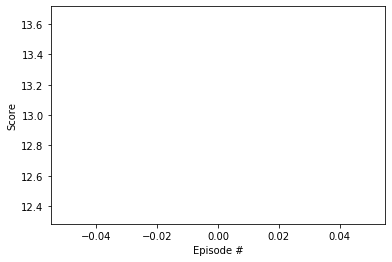

In [61]:
def hill_climb(nA,agent,env,n_episodes=1800, max_t=200):
    scores = []
    scores_window = deque(maxlen=100)
    index = 0
    for i_episode in range(1,n_episodes+1):
        state = env.reset()
        previous_score = 0
        score = 0
        best_agent = agent
        for t in range(max_t):
            action_probs = agent(state)[0]
            print('action_probs',action_probs.detach().numpy())
            action = np.random.choice(np.arange(nA),p=action_probs.detach().numpy())
            print('action',action)
            next_state,reward,done,_ = env.step(action)
#             agent.step(state,action,reward,next_state,done,index)
            state = next_state
            score += reward
            index += 1
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        if previous_score > score:
            for parameter in agent.parameters():
                parameter.data.copy_(previous_weights.data)
        else:
            for parameter in agent.parameters():
                parameter.data.copy_(parameter.data + np.random.rand()/100)
        break
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)),end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores
    
    
agent = Agent(env)
scores = hill_climb(nA,agent,env)
plot(scores)

## Annealing

## Cross Entropy Method (CEM)

2


/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 10	Average Score: 44.80
rewards [ 10.  79.  40.  24.  10.   9.  16.   9.  10.  95.  28.  30.  26. 132.
  13.  97.  10.  24.  24.  11.  16.  11.  13.  15.  16.  10.  10.  53.
  35.  13.  35.   9.  39.  22.  47.  42.   9.  20.   9.  75.  12. 113.
  21.   9.  12.  35.   9.  10.   8.  59.]
Episode 20	Average Score: 91.75
rewards [200.  24.  58. 152. 164. 143. 103. 117. 200.  69.  25.  11. 164.  10.
 108.  12. 119.  18. 106.  27. 124.  68.  79.  90.  53. 161. 166. 137.
  11. 200.  40.  58.  32. 109.  33.  44. 200. 150. 200.  45.  88.  35.
 122. 130. 111.  26.  63.  79.  58. 107.]
Episode 30	Average Score: 127.83
rewards [130.  26.  39. 119. 200.  21. 186. 168. 200. 179.  19. 200. 200.  94.
  64.  29. 200.  35. 200. 200. 174.  21. 200.   8. 102. 200. 200. 200.
 200. 119. 200. 200. 200. 200. 193.  32.  94. 200. 169.  23. 173.  23.
  17. 200. 200.  46. 200. 180. 200. 200.]
Episode 40	Average Score: 145.88
rewards [200. 183. 105. 200. 200.  74. 200. 200. 123.  64.  17. 200. 200.  98.
 1

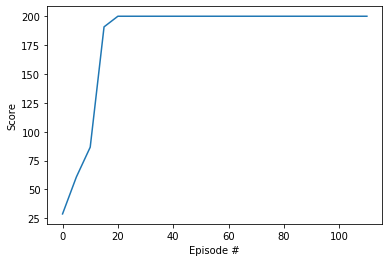

In [64]:
def agent_cem(agent,n_iterations=200,print_every=10,max_t=500,gamma=0.99,population=50,elite_frac=0.2,sigma=0.5):
    n_elite = int(population*elite_frac)
    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = sigma*np.random.randn(agent.get_weights_dim())
    
    for i_iteration in range(1,n_iterations+1):
        weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(population)]
        rewards = np.array([agent.evaluate(weights,gamma,max_t) for weights in weights_pop])
        
        elite_idx = rewards.argsort()
#         print('elite_idx',elite_idx)
#         print('np.arange(population-n_elite,population)',np.arange(population-n_elite,population))
        elite_select = elite_idx[np.arange(population-n_elite,population)]
#         print('elite_select',elite_select)
        elite_weights = [weights_pop[i] for i in elite_select]
        best_weight = np.array(elite_weights).mean(axis=0)
        
        reward = agent.evaluate(best_weight,gamma)
        scores_deque.append(reward)
        scores.append(reward)
        
        torch.save(agent.state_dict(),'cem_checkpoint.pth')
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))
            print('rewards',rewards)
            
        if np.mean(scores_deque)>=195.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    
    return scores
    
print(env.action_space.n)
agent = Agent(env)
scores = agent_cem(agent)
plot(scores)

## REINFORCE

In [66]:
from torch.distributions import Categorical

In [129]:
class Policy_m(nn.Module):
    def __init__(self,nS,nA,hidden_dims=(16,16)):
        super(Policy_m,self).__init__()
        print('nS,nA',nS,nA)
        self.fc1 = nn.Linear(nS,hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0],hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[-1],nA)
        
    def forward(self,state):
        x = state
        if not isinstance(state,torch.Tensor):
            x = torch.tensor(x,dtype=torch.float32) #device = self.device,
            x = x.unsqueeze(0)
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x,dim=1)
    
    def act(self,state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item(),m.log_prob(action)

In [130]:
# policy_m = Policy_m(nS,nA)
# policy = Policy_m(nS,nA).to(device)
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr = 1e-2)
env = gym.make('CartPole-v0')
env.seed(0)

def reinforce_2(env,policy,optimizer,n_episodes=1000, max_t=1000, gamma=0.99, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1,n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action,log_prob = policy.act(state)
            state,reward,done,_ = env.step(action)
            saved_log_probs.append(log_prob)
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards))]
        R = sum([a*b for a,b in zip(discounts,rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores

scores = reinforce_2(env,policy,optimizer)
            
    

Episode 100	Average Score: 24.08
Episode 200	Average Score: 37.82
Episode 300	Average Score: 47.01
Episode 400	Average Score: 49.64
Episode 500	Average Score: 55.60
Episode 600	Average Score: 53.09
Episode 700	Average Score: 41.99
Episode 800	Average Score: 55.57
Episode 900	Average Score: 61.78
Episode 1000	Average Score: 68.50


In [123]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

observation space: Box(4,)
action space: Discrete(2)


In [124]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(env,policy,n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
scores = reinforce(env,policy)

Episode 100	Average Score: 32.46
Episode 200	Average Score: 48.34
Episode 300	Average Score: 76.95
Episode 400	Average Score: 135.24
Episode 500	Average Score: 92.40
Episode 600	Average Score: 139.46
Episode 700	Average Score: 150.47
Environment solved in 670 episodes!	Average Score: 195.23


# Loss functions

Categorical cross entropy:
The final layer is a softmax, and then cross entropy

−(ylog(p)+(1−y)log(1−p))

In [ ]:
def CrossEntropy(yhat,y):
    if y == 1:
        return -log(yhat)
    else:
        return -log(1 - yhat)
    
# short form
def CE(yhat,y):
    return -log((-1+y) + yhat)

# multiclass
def MCE(yhat,y):
    # if they are vectors
    return -log(np.add(yhat,np.add(y,-1)))
    

In [ ]:
# Reinforce again
class Policy(nn.Module):
    def __init__(self,nS,nA,seed,hidden_dims=(32,32)):
        super(Policy,self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear()
        self.fc2 = nn.Linear()
        self.fc = nn.ModuleList()
        
    def forward(self):
        pass
    
    def act(self):
        pass
    
    

In [ ]:
def train(agent,env,i_episode=2,gamma=1.0):
    trajectories = []
    rewards = []
    scores = []
    for i_episode in range(n_episodes):
        state = env.reset()
        logs = []
        for t in range(t_max):
            
            action,log_probs = agent.act(state)
            next_state,reward,done,_ = env.step(action)
            rewards.append(reward)
            logs.append(log_probs)
            trajectories.append((state,action,reward,next_state))
            state = next_state
        discounted_rewards = [reward*(gamma**i) for i,reward in enumerate(rewards)]
        gradient = sum([d_reward * log for d_reward,log in zip(discounted_rewards,logs)]) 
        # Update parameters
        optimizer.zero_grad()
        learning_rate * gradient
        optimizer.backward()
        

In [ ]:
# Reward normalization

def norm_train(agent,env,i_episode=2,gamma=1.0):
    trajectories = []
    rewards = []
    scores = []
    for i_episode in range(n_episodes):
        state = env.reset()
        logs = []
        for t in range(t_max):
            
            action,log_probs = agent.act(state)
            next_state,reward,done,_ = env.step(action)
            rewards.append(reward)
            logs.append(log_probs)
            trajectories.append((state,action,reward,next_state))
            state = next_state
            
        mean_r = np.mean(rewards)
        N = len(rewards)
        sigma_r = np.sqrt(sum((rewards-mean_r)**2)/N)
        norm_r = rewards - mean_r / simga_r
        
        
        discounted_rewards = [reward*(gamma**i) for i,reward in enumerate(rewards)]
        gradient = sum([d_reward * log for d_reward,log in zip(discounted_rewards,logs)]) 
        # Update parameters
        optimizer.zero_grad()
        learning_rate * gradient
        optimizer.backward()

In [ ]:
# Future rewards

def future_train(agent,env,i_episode=2,gamma=1.0):
    trajectories = []
    rewards = []
    scores = []
    for i_episode in range(n_episodes):
        state = env.reset()
        logs = []
        for t in range(t_max):
            
            action,log_probs = agent.act(state)
            next_state,reward,done,_ = env.step(action)
            rewards.append(reward)
            logs.append(log_probs)
            trajectories.append((state,action,reward,next_state))
            state = next_state
        future_rewards = [sum(rewards[i:]) for i in range(rewards)]
        discounted_rewards = [reward*(gamma**i) for i,reward in enumerate(future_rewards)]
        gradient = sum([d_reward * log for d_reward,log in zip(discounted_rewards,logs)]) 
        # Update parameters
        optimizer.zero_grad()
        learning_rate * gradient
        optimizer.backward()

# PPO

Proximal Policy Optimization
